<a href="https://colab.research.google.com/github/ludovicolanni/neural-music-composer/blob/master/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation: Input and Labels

In [ ]:
!pip install pretty-midi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pretty_midi

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
import pickle 

# let's define a function for saving the dictionary to disk

def save_obj(obj,filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        
# let's define a function for loading the dictionary from disk

def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [ ]:
# load the dictionary after extraction and transformation into textual format

music = load_obj('/content/drive/My Drive/music.pkl')

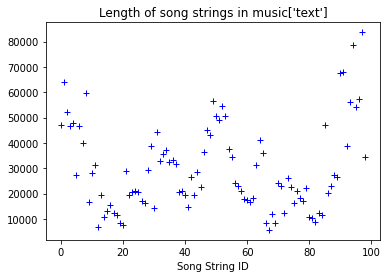

In [ ]:
# check the size of the song strings

plt.figure()
plt.plot([len(i) for i in music['text']],'b+')
plt.title("Length of song strings in music['text']")
plt.xlabel('Song String ID')
plt.show()

In [ ]:
# let's reduce the size of the dataset for memory concerns

# we select only the songs that have a length lower than 20000 characters

reduced_music_text = list(np.array(music['text'])[np.array([len(i) for i in music['text']])<20000])

print('number of songs in reduced_music_text: ', len(reduced_music_text))

number of songs in reduced_music_text:  34


In [ ]:
# now we store the index of each song we kept in the reduced dataset corresponding to their original position in the dictionary, in case we need this info later.

original_position = {}

for i in range(len(reduced_music_text)):
  original_position[i] = np.argwhere((np.array([len(i) for i in music['text']])<20000)==True).flatten()[i]

original_position

{0: 9,
 1: 12,
 2: 13,
 3: 14,
 4: 15,
 5: 16,
 6: 17,
 7: 18,
 8: 19,
 9: 20,
 10: 22,
 11: 26,
 12: 27,
 13: 30,
 14: 40,
 15: 41,
 16: 43,
 17: 59,
 18: 60,
 19: 61,
 20: 62,
 21: 66,
 22: 67,
 23: 68,
 24: 69,
 25: 72,
 26: 75,
 27: 77,
 28: 78,
 29: 80,
 30: 81,
 31: 82,
 32: 83,
 33: 84}

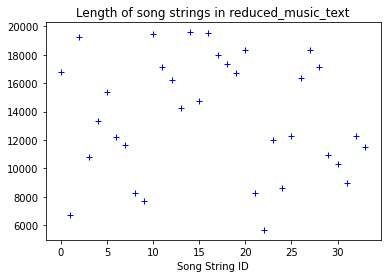

In [ ]:
# check the size of the song strings in the very much reduced version of the dataset

plt.figure()
plt.plot([len(i) for i in reduced_music_text],'b+')
plt.title("Length of song strings in reduced_music_text")
plt.xlabel('Song String ID')
plt.show()

In [ ]:
# let's use the split proposed by the original MAESTRO dataset

original_split = [
                  music['splits'][original_position[i]] 
                  for i in range(len(reduced_music_text))
                  ]

print(original_split)

music_train=[]
music_test=[]
music_validation=[]

for i,split in enumerate(original_split):
  if split=='train':
    music_train.append(reduced_music_text[i])
  elif split=='test':
    music_test.append(reduced_music_text[i])
  else:
    music_validation.append(reduced_music_text[i])

print('\nnumber of training song strings: ', len(music_train))
print('number of test song strings: ', len(music_test))
print('number of validation song strings: ', len(music_validation))


['train', 'train', 'train', 'test', 'train', 'train', 'test', 'test', 'train', 'train', 'test', 'train', 'train', 'train', 'train', 'train', 'train', 'validation', 'validation', 'validation', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'train', 'validation', 'train']

number of training song strings:  26
number of test song strings:  4
number of validation song strings:  4


In [ ]:
# get the character vocabulary of the corpus

# List of unique characters in the corpus of all songs
chars = sorted(list(set("".join(reduced_music_text))))
print('Unique characters: ', len(chars))

# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)
print()
print(char_indices)

# save the vocabulary
save_obj(char_indices,'/content/drive/My Drive/char_indices.pkl')

Unique characters:  22

{' ': 0, '#': 1, '-': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'e': 20, '|': 21}


In [ ]:
# we are ready to prepare the one-hot-encoded data for neural networks

# we define a function to do so

def char_one_hot_encode(data, vocabulary, maxlen=512, step=3):

  ''' This function divides each element in a list of strings into sequences of length <maxlen> with sample step of size <step>, identifying the next character for each of these sequences. 
  Using the <vocabulary> dictionary, it returns two objects: 
  x: the 3D binary array of sequences where each character has been one-hot encoded;
  y: the 2D binary array of the next one-hot encoded character for each sequence in x'''

  # Length of extracted character sequences
  maxlen = 512

  # We sample a new sequence every `step` characters
  step = 3

  # This holds our extracted sequences
  sentences = []

  # This holds the targets (the follow-up characters)
  next_chars = []


  for text in data:

      for i in range(0, len(text) - maxlen, step):
          sentences.append(text[i: i + maxlen])
          next_chars.append(text[i + maxlen])

  print('Number of sequences:', len(sentences))


  # Next, one-hot encode the characters into binary arrays.
  print('Vectorization...')
  x = np.zeros((len(sentences), maxlen, len(vocabulary)), dtype=np.bool)
  y = np.zeros((len(sentences), len(vocabulary)), dtype=np.bool)
  for i, sentence in enumerate(sentences):
      for t, char in enumerate(sentence):
          x[i, t, vocabulary[char]] = 1
      y[i, vocabulary[next_chars[i]]] = 1
  
  return x,y

In [ ]:
# we apply the function to each dataset sharing the same vocabulary

# training

print('TRAINING DATA')
x_train,y_train = char_one_hot_encode(data=music_train,
                                      vocabulary=char_indices,
                                      maxlen=512,
                                      step=3)

print('size of x_train: ', x_train.shape)
print('size of y_train: ', y_train.shape,'\n')

# test

print('TEST DATA')
x_test,y_test = char_one_hot_encode(data=music_test,
                                      vocabulary=char_indices,
                                      maxlen=512,
                                      step=3)

print('size of x_test: ', x_test.shape)
print('size of y_test: ', y_test.shape,'\n')

# validation

print('VALIDATION DATA')
x_validation,y_validation = char_one_hot_encode(data=music_validation,
                                      vocabulary=char_indices,
                                      maxlen=512,
                                      step=3)

print('size of x_validation: ', x_validation.shape)
print('size of y_validation: ', y_validation.shape,'\n')

TRAINING DATA
Number of sequences: 111439
Vectorization...
size of x_train:  (111439, 512, 22)
size of y_train:  (111439, 22) 

TEST DATA
Number of sequences: 17357
Vectorization...
size of x_test:  (17357, 512, 22)
size of y_test:  (17357, 22) 

VALIDATION DATA
Number of sequences: 20748
Vectorization...
size of x_validation:  (20748, 512, 22)
size of y_validation:  (20748, 22) 



In [ ]:
# let's save the numpy arrays to my drive storage

np.save('/content/drive/My Drive/x_train.npy', x_train)
np.save('/content/drive/My Drive/y_train.npy', y_train)
np.save('/content/drive/My Drive/x_test.npy', x_test)
np.save('/content/drive/My Drive/y_test.npy', y_test)
np.save('/content/drive/My Drive/x_validation.npy', x_validation)
np.save('/content/drive/My Drive/y_validation.npy', y_validation)